In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy

%matplotlib inline
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center')

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Abrir el archivo CSV para lectura
with open('textosLimpiosLemmatization.csv', mode='r') as csv_file:
    reader = csv.reader(csv_file)

    # Inicializar los arrays
    X = []
    y = []

    # Leer cada fila del archivo CSV
    for row in reader:
        for i in range(len(row)):
            if i % 2 == 0:
                X.append(row[i])
            else:
                y.append(row[i])
XLemmatization = np.array(X)
yLemmatization = np.array(y)

# Abrir el archivo CSV para lectura
with open('textosLimpiosPorterStemmer.csv', mode='r') as csv_file:
    reader = csv.reader(csv_file)

    # Inicializar los arrays
    X = []
    y = []

    # Leer cada fila del archivo CSV
    for row in reader:
        for i in range(len(row)):
            if i % 2 == 0:
                X.append(row[i])
            else:
                y.append(row[i])
XPorterStemmer = np.array(X)
yPorterStemmer = np.array(y)

In [3]:
(ratings,conteo) = np.unique(yLemmatization,return_counts=True)
pd.DataFrame({'Rating': ratings, 'Conteo': conteo})

,Rating,Conteo
0,1.0 out of 5 stars,1913
1,2.0 out of 5 stars,1512
2,3.0 out of 5 stars,1918
3,4.0 out of 5 stars,1955
4,5.0 out of 5 stars,1971


# División entre conjuntos de Train, Validación y Test

Vamos a utilizar una división planteada mediante un  `Stratified Shuffle Split` por los siguientes motivos:

1. Nos decantamos por la opción `Shuffle Split` ya que tenemos una cantidad de elementos en cada conjunto bastante balanceado por lo que no vamos a tener problemas al momento de realizar las particiones. Se elegiran ejemplos de manera aleatoria de cada grupo pero manteniendo un porcentaje parecido entre estos. No dividimos en grupos fijos sino en cada iteración dividimos de manera aleatoria asi probamos nuestros modelos en diferentes escenarios.

2. Realizamos la separación `Stratified` para poder asegurarnos tener ejemplos de cada clase en cada una de las iteraciones.

Realizamos la division de datos para separar los datos train y validación con los de test

In [1]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def divisionDatos(X,y):
    X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=1)
    return X_train_val,y_train_val,X_test,y_test

In [6]:
X_train_val,y_train_val,X_test,y_test = divisionDatos(XLemmatization,yLemmatization)

(ratings,conteo) = np.unique(y_test,return_counts=True)
pd.DataFrame({'Rating': ratings, 'Conteo': conteo})

,Rating,Conteo
0,1.0 out of 5 stars,383
1,2.0 out of 5 stars,302
2,3.0 out of 5 stars,384
3,4.0 out of 5 stars,391
4,5.0 out of 5 stars,394


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, train_size=0.7, random_state=1)
for i, (train_index, test_index) in enumerate(sss.split(X_train_val, y_train_val)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index} // size={train_index.size}")
    print(f"  Test:  index={test_index} // size={test_index.size}")

Fold 0:
  Train: index=[2482 3947 6610 ... 3488 6208 4134] // size=5190
  Test:  index=[1010 5259 6057 ...  182 4147 6138] // size=2225
Fold 1:
  Train: index=[6323 6996   25 ... 5038 3258  884] // size=5190
  Test:  index=[3499 4407 2372 ...  135 5023 2512] // size=2225
Fold 2:
  Train: index=[3360 1791 3493 ... 6172 5121 4731] // size=5190
  Test:  index=[5092  941 5639 ... 5600 4543 3903] // size=2225
Fold 3:
  Train: index=[1219 3322 5407 ...  653 5785  286] // size=5190
  Test:  index=[3816 3987 6596 ... 7144 2298 4453] // size=2225
Fold 4:
  Train: index=[6380 1959  938 ... 4642 5252 1960] // size=5190
  Test:  index=[ 537 6259 6369 ... 1263 3513 4443] // size=2225


# Clasificadores

In [6]:
def crearClasificador(X,y,param_grid,divisionDatos,scorer,pipeline=None):
    clasificador = GridSearchCV(pipeline, param_grid, cv=divisionDatos, n_jobs=-1, scoring=scorer)
    clasificador = clasificador.fit(X,y)
    return clasificador

In [7]:
def mostrarResultados(clasificador,X,y):
    y_true, y_pred = y , clasificador.predict(X)
    print('\nResults on the test set:')
    print(classification_report(y_true, y_pred))
    # print("{} OBTENIDO {}".format(scorer.upper(),makeScorer(y_true, y_pred)))

In [8]:
def mostrarMatrizConfusion(clasificador,X,y):
    class_names = ['1.0 out of 5 stars', '2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars']
    class_namesMatrix = ['1 Est.', '2 Est.', '3 Est.', '4 Est.', '5 Est.']
    y_true, y_pred = y , clasificador.predict(X)
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_namesMatrix)
    return disp,cm

In [9]:
scorer = 'accuracy'
scorerRegression = 'r2'

def makeScorer(y_true,y_pred):
    return accuracy_score(y_true, y_pred)

def makeScorerRegression(y_true,y_pred):
    return r2_score(y_true, y_pred)

## Eleccion CountVectorizer o TfidfVectorizer

In [10]:
from sklearn.naive_bayes import MultinomialNB

def eleccionVectorizer(X,y,vectorizer,divisionDatos,scorer):
    pipeline = Pipeline([('vectorizer', vectorizer),
                        ('clasificador', MultinomialNB())])
    
    param_grid = {}
    
    return crearClasificador(X,y,param_grid,divisionDatos,scorer,pipeline)


Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.47      0.55      0.51       383
2.0 out of 5 stars       0.26      0.21      0.23       302
3.0 out of 5 stars       0.30      0.29      0.29       384
4.0 out of 5 stars       0.39      0.30      0.34       391
5.0 out of 5 stars       0.53      0.64      0.58       394

          accuracy                           0.41      1854
         macro avg       0.39      0.40      0.39      1854
      weighted avg       0.39      0.41      0.40      1854





Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.47      0.55      0.51       383
2.0 out of 5 stars       0.27      0.22      0.24       302
3.0 out of 5 stars       0.31      0.29      0.30       384
4.0 out of 5 stars       0.38      0.29      0.33       391
5.0 out of 5 stars       0.53      0.66      0.59       394

          accuracy                      

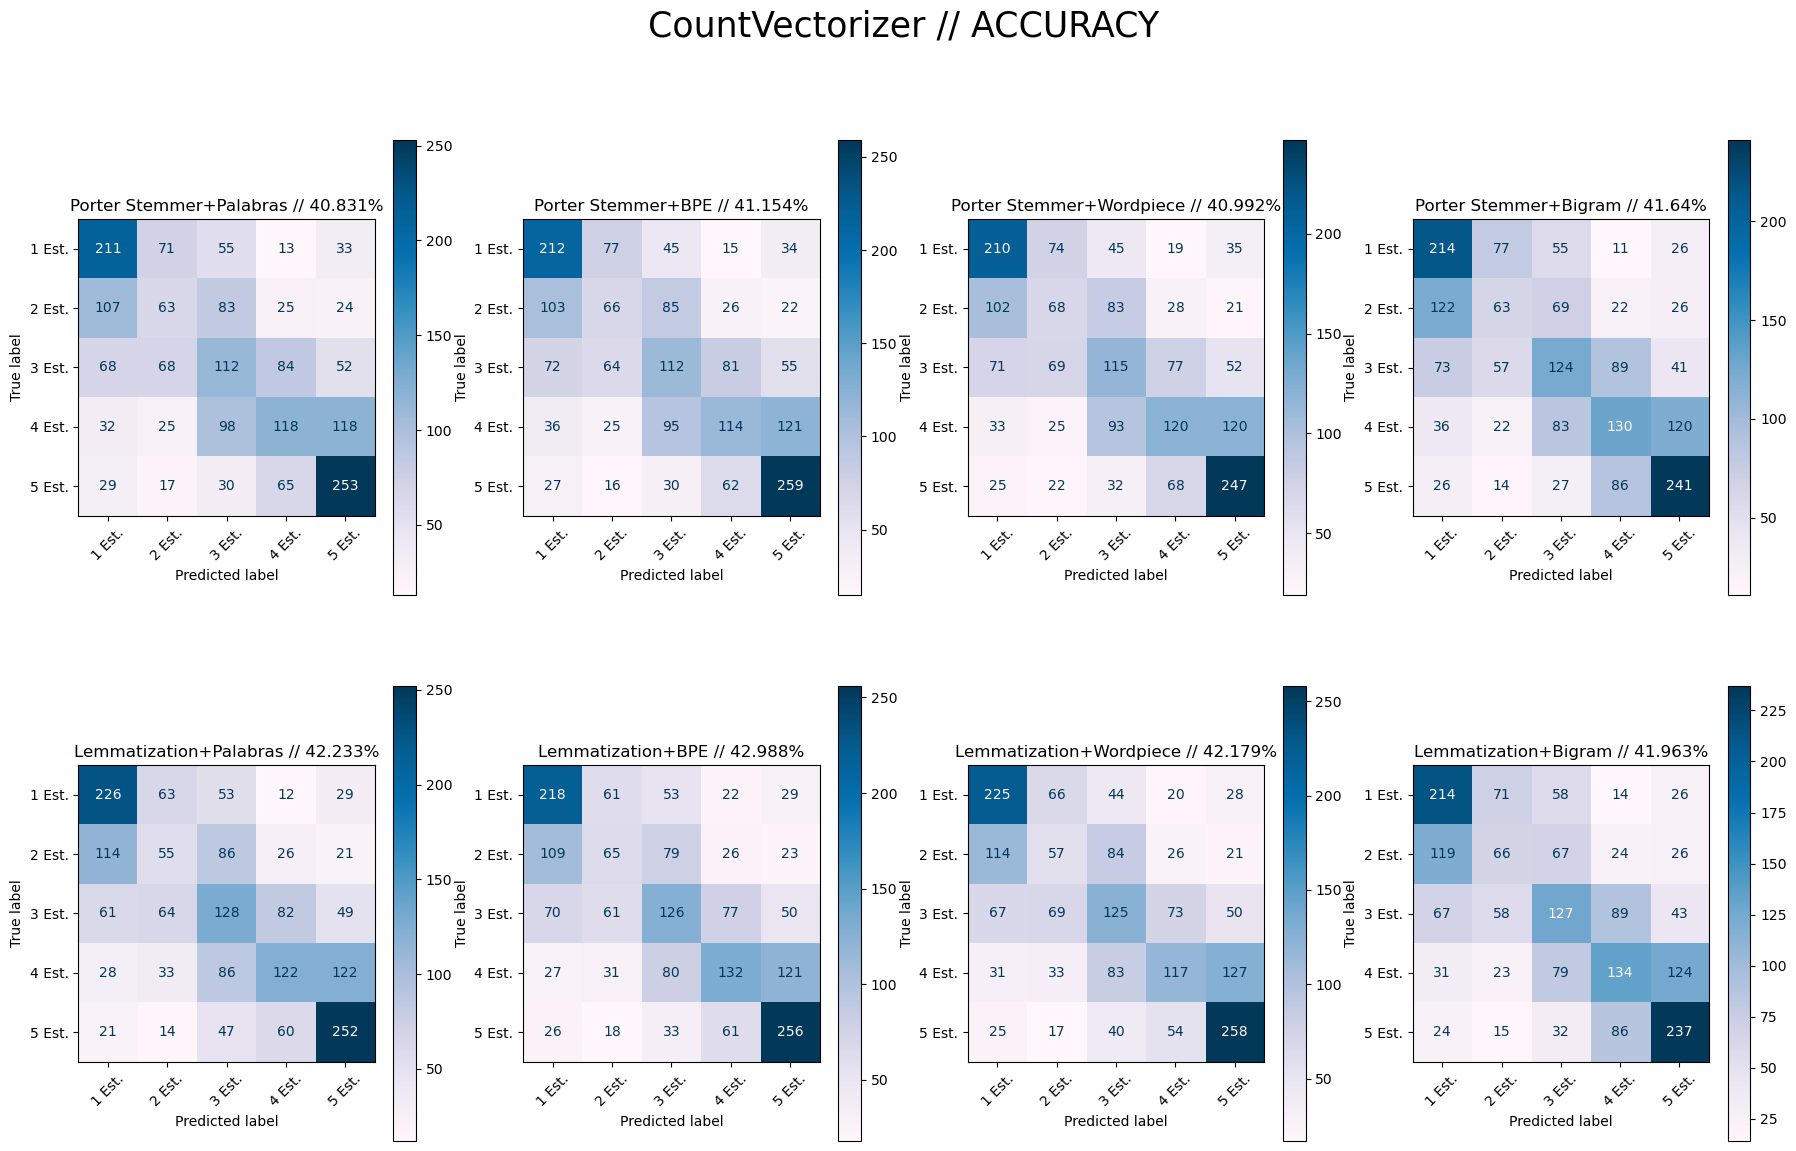

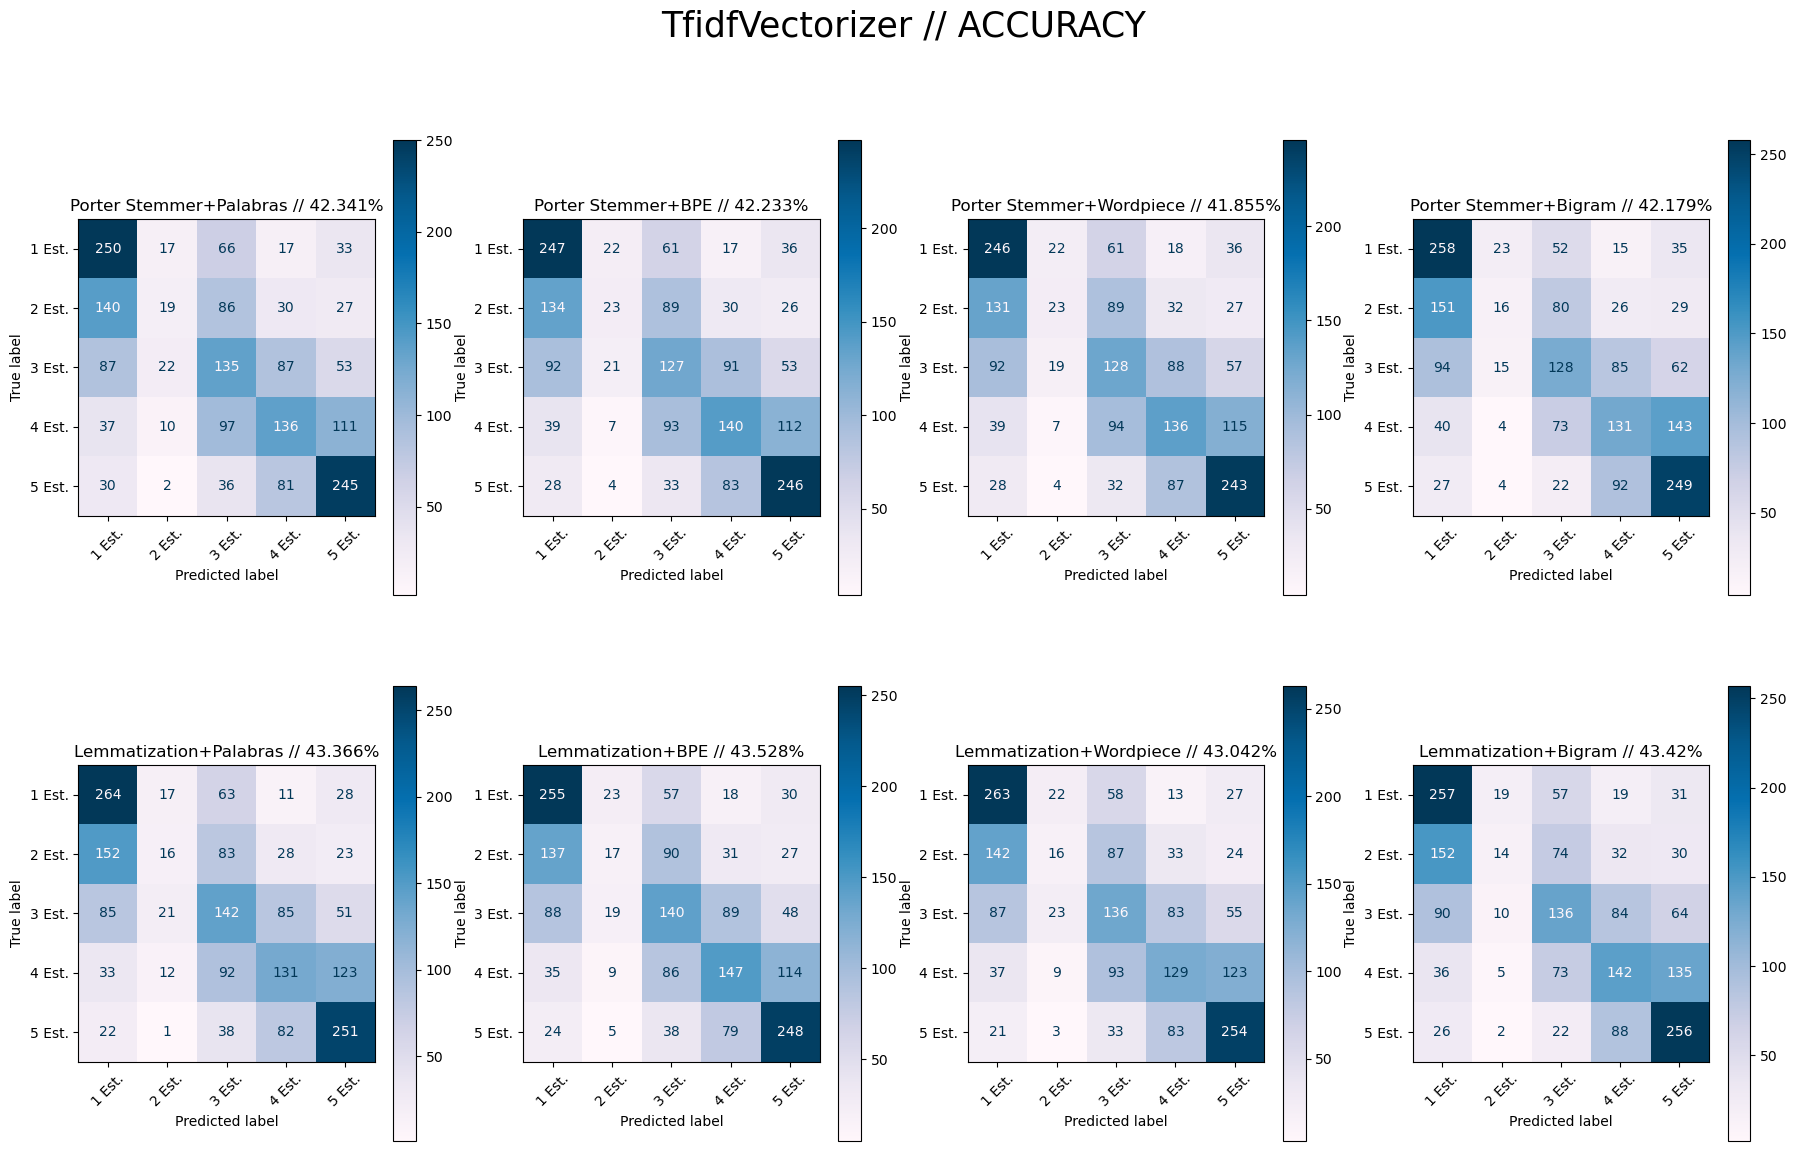

In [11]:
from nltk import ngrams
from tokenizers import CharBPETokenizer, BertWordPieceTokenizer  # conda install -c conda-forge tokenizers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def tokenizeBPE(text):
    encoding = token[0].encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

def tokenizeWordpiece(text):
    encoding = token[0].encode(text)
    return encoding.tokens

def tokenizeBigram(text):
    words = text.split()
    bigrams = [words[i] + " " + words[i+1] for i in range(len(words)-1)]
    return bigrams

bestClasifier = [-np.Inf,None,None]

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

tipoVectorizer = [(CountVectorizer,'CountVectorizer'),(TfidfVectorizer,'TfidfVectorizer')]
tipoLimpieza = [(XPorterStemmer,yPorterStemmer,'Porter Stemmer'),(XLemmatization,yLemmatization,'Lemmatization')]
tipoTokenizers = [(None,'Palabras'),(CharBPETokenizer(),'BPE'),(BertWordPieceTokenizer(),'Wordpiece'),(None,'Bigram')]

for vectorizer in tipoVectorizer:
    fig, axesTotal = plt.subplots(2,4, figsize=(22,13))
    
    for datos,axes in zip(tipoLimpieza,axesTotal):
        X_train_val,y_train_val,X_test,y_test = divisionDatos(datos[0],datos[1])
        for token,ax in zip(tipoTokenizers,axes):
            
            if(token[0] != None):
                token[0].train_from_iterator(X_train_val)
                if(token[1] == 'BPE'):
                    clasificador = eleccionVectorizer(X_train_val,y_train_val,vectorizer[0](tokenizer=tokenizeBPE,max_df=0.05),sss,scorer)
                elif(token[1] == 'Wordpiece'):
                    clasificador = eleccionVectorizer(X_train_val,y_train_val,vectorizer[0](tokenizer=tokenizeWordpiece,max_df=0.05),sss,scorer) 
            else:
                if(token[1] == 'Palabras'):
                    clasificador = eleccionVectorizer(X_train_val,y_train_val,vectorizer[0](tokenizer=token[0],max_df=0.05),sss,scorer)
                elif(token[1] == 'Bigram'):
                    clasificador = eleccionVectorizer(X_train_val,y_train_val,vectorizer[0](tokenizer=tokenizeBigram,max_df=0.05),sss,scorer)
                    
            if(bestClasifier[0] < np.round(makeScorer(y_test, clasificador.predict(X_test))*100,3)):
                bestClasifier[0] = np.round(makeScorer(y_test, clasificador.predict(X_test))*100,3)
                bestClasifier[1] = clasificador
                disp,cm = mostrarMatrizConfusion(clasificador,X_test,y_test)
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                bestClasifier[2] = cm.diagonal()
                mostrarResultados(clasificador,X_test,y_test)

            ax.set_title("{} // {}%".format(datos[2]+'+'+token[1],np.round(makeScorer(y_test, clasificador.predict(X_test))*100,3)))
            disp,_ = mostrarMatrizConfusion(clasificador,X_test,y_test)
            disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)

    fig.suptitle('{} // {}'.format(vectorizer[1],scorer.upper()), fontsize=25)
    fig.tight_layout
print(bestClasifier)

In [12]:
bestClasifier[1]

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.05,
                                                        tokenizer=<function tokenizeBPE at 0x7f1a599d4b80>)),
                                       ('clasificador', MultinomialNB())]),
             n_jobs=-1, param_grid={}, scoring='accuracy')

# Resto Clasificadores

In [13]:
X_train_val,y_train_val,X_test,y_test = divisionDatos(XLemmatization,yLemmatization)

In [14]:
class_names = ['1.0 out of 5 stars', '2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars']

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

# Definir las categorías y asignarles un valor numérico único
label_encoder = LabelEncoder()
label_encoder.fit(['1.0 out of 5 stars', '2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars'])

y_train_val_label = label_encoder.transform(np.array(y_train_val))
print(y_train_val_label)
y_test_label = label_encoder.transform(np.array(y_test))
print(y_test_label)

[1 1 0 ... 1 0 1]
[3 0 2 ... 2 4 3]


## Regresión Logistica

/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not con

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05,
                                 tokenizer=<function tokenizeBPE at 0x7ff26d0d7700>)),
                ('clasificador',
                 LogisticRegression(C=1, max_iter=10000, multi_class='ovr',
                                    random_state=1, solver='newton-cg'))])

Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.50      0.61      0.55       383
2.0 out of 5 stars       0.30      0.16      0.21       302
3.0 out of 5 stars       0.34      0.32      0.33       384
4.0 out of 5 stars       0.37      0.34      0.35       391
5.0 out of 5 stars       0.51      0.66      0.57       394

          accuracy                           0.43      1854
         macro avg       0.40      0.42      0.40      1854
      weighted avg       0.41      0.43      0.41      1854

[0.60574413 0.1589404  0.32291667 0.33759591 0.65989848]


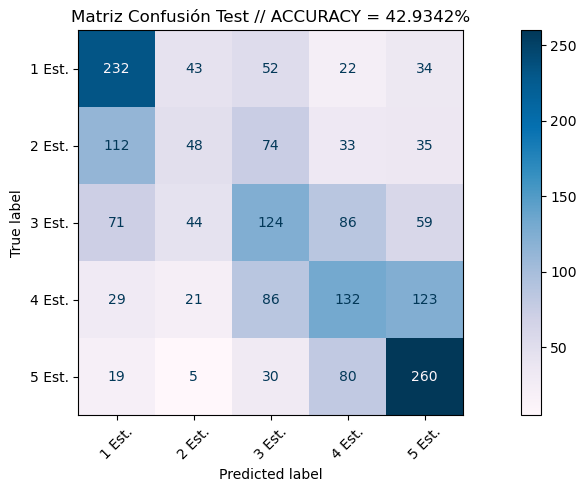

In [67]:
'''
REGRESIÓN LOGISTICA DE N VARIABLES
'''
def tokenizeBPE(text):
    encoding = tokenizer.encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

# Se importa la libreria correspondiente
from sklearn.linear_model import LogisticRegression

#Creo la pipeline necesaria para automatizar el proceso
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizeBPE,max_df=0.05)),
    ('clasificador', LogisticRegression(max_iter=10000, random_state=1))
])

# Genera el diccionario param_grid con los valores indicados
param_grid = {
    'clasificador__penalty': ['l2',None],
    'clasificador__C': [1e+101, 1, 1e-101],
    'clasificador__solver': ['newton-cg', 'sag', 'saga'],
    'clasificador__multi_class': ['auto', 'ovr', 'multinomial']
}

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

#Creo el objeto GridSearchCV para crear los mejores parametros
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(X_train_val)
clasificador = crearClasificador(X_train_val,y_train_val,param_grid,sss,scorer,pipeline)
print(clasificador.best_estimator_)

# Mostramos los datos mas interesantes de cada variable predicha
mostrarResultados(clasificador,X_test,y_test)

# Obtenemos la matriz de confusión
disp,cm = mostrarMatrizConfusion(clasificador,X_test,y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())
fig, ax = plt.subplots(1, figsize=(15,5))
ax.set_title("Matriz Confusión Test // {} = {}%".format(scorer.upper(),np.round(makeScorer(y_test, clasificador.predict(X_test))*100,4)))
disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)

## Red Neuronal

/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/julen/anaconda3/envs/py38ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warning

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05,
                                 tokenizer=<function tokenizeBPE at 0x7ff20b1fddc0>)),
                ('clasificador',
                 MLPClassifier(alpha=0.2, hidden_layer_sizes=(50, 50),
                               max_iter=2000, random_state=1))])

Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.48      0.49      0.49       383
2.0 out of 5 stars       0.27      0.25      0.26       302
3.0 out of 5 stars       0.33      0.29      0.31       384
4.0 out of 5 stars       0.36      0.44      0.39       391
5.0 out of 5 stars       0.53      0.49      0.51       394

          accuracy                           0.40      1854
         macro avg       0.39      0.39      0.39      1854
      weighted avg       0.40      0.40      0.40      1854

[0.48563969 0.25165563 0.29166667 0.4398977  0.48730964]


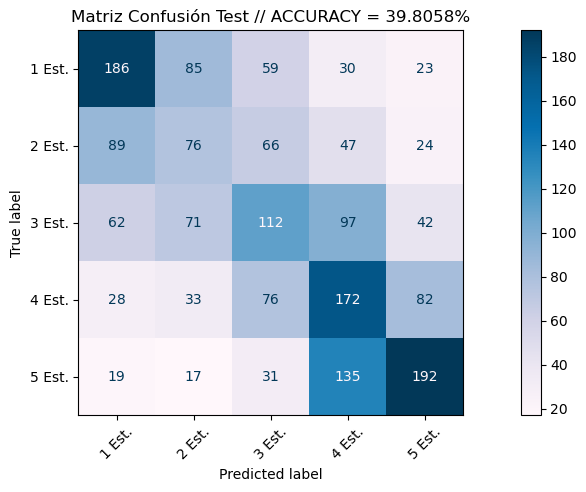

In [76]:
'''
RED NEURONAL
'''
def tokenizeBPE(text):
    encoding = tokenizer.encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

# Se importa la libreria correspondiente
from sklearn.neural_network import MLPClassifier

#Creo la pipeline necesaria para automatizar el proceso
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizeBPE,max_df=0.05)),
    ('clasificador', MLPClassifier(activation = 'relu', max_iter = 2000, random_state=1))
])

# Genera el diccionario param_grid con los valores indicados
param_grid = {
    'clasificador__hidden_layer_sizes': [(15, 30), (50, 50), (25, 75)],
    'clasificador__solver': ['sgd', 'adam'],
    'clasificador__alpha': [0.1, 0.2, 0.35],
    'clasificador__learning_rate': ['constant','adaptive'],
}

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

#Creo el objeto GridSearchCV para crear los mejores parametros
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(X_train_val)
clasificador = crearClasificador(X_train_val,y_train_val,param_grid,sss,scorer,pipeline)
print(clasificador.best_estimator_)

# Mostramos los datos mas interesantes de cada variable predicha
mostrarResultados(clasificador,X_test,y_test)

# Obtenemos la matriz de confusión
disp,cm = mostrarMatrizConfusion(clasificador,X_test,y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())
fig, ax = plt.subplots(1, figsize=(15,5))
ax.set_title("Matriz Confusión Test // {} = {}%".format(scorer.upper(),np.round(makeScorer(y_test, clasificador.predict(X_test))*100,4)))
disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)

## SVMs




Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05,
                                 tokenizer=<function tokenizeBPE at 0x7ff20a61f5e0>)),
                ('clasificador',
                 SVC(C=0.5, decision_function_shape='ovo', gamma=3,
                     kernel='linear', random_state=1))])

Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.51      0.59      0.55       383
2.0 out of 5 stars       0.35      0.16      0.22       302
3.0 out of 5 stars       0.33      0.34      0.34       384
4.0 out of 5 stars       0.34      0.42      0.38       391
5.0 out of 5 stars       0.55      0.55      0.55       394

          accuracy                           0.43      1854
         macro avg       0.42      0.41      0.41      1854
      weighted avg       0.42      0.43      0.42      1854

[0.59007833 0.16225166 0.34114583 0.42455243 0.54822335]


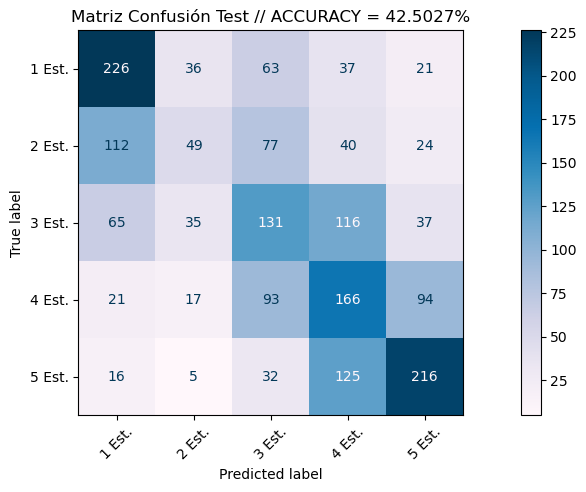

In [83]:
'''
SVM
'''
def tokenizeBPE(text):
    encoding = tokenizer.encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

# Se importa la libreria correspondiente
from sklearn.svm import SVC

#Creo la pipeline necesaria para automatizar el proceso
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizeBPE,max_df=0.05)),
    ('clasificador', SVC(random_state=1))
])

# Genera el diccionario param_grid con los valores indicados
param_grid = {
    'clasificador__C': [0.5, 2, 1], 
    'clasificador__kernel': ['linear', 'rbf', 'sigmoid'],
    'clasificador__gamma': [3, 5, 10],
    'clasificador__decision_function_shape': ['ovo', 'ovr']
}

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

#Creo el objeto GridSearchCV para crear los mejores parametros
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(X_train_val)
clasificador = crearClasificador(X_train_val,y_train_val,param_grid,sss,scorer,pipeline)
print(clasificador.best_estimator_)

# Mostramos los datos mas interesantes de cada variable predicha
mostrarResultados(clasificador,X_test,y_test)

# Obtenemos la matriz de confusión
disp,cm = mostrarMatrizConfusion(clasificador,X_test,y_test)
print(cm.diagonal()/cm.sum(axis=1))
fig, ax = plt.subplots(1, figsize=(15,5))
ax.set_title("Matriz Confusión Test // {} = {}%".format(scorer.upper(),np.round(makeScorer(y_test, clasificador.predict(X_test))*100,4)))
disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)

## Ensembles - GradientBoosting

### Clasificacion




Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05,
                                 tokenizer=<function tokenizeBPE at 0x7ff20a9405e0>)),
                ('clasificador',
                 GradientBoostingClassifier(max_features='sqrt',
                                            min_samples_leaf=10,
                                            n_estimators=500,
                                            random_state=1))])

Results on the test set:
                    precision    recall  f1-score   support

1.0 out of 5 stars       0.54      0.45      0.49      1913
2.0 out of 5 stars       0.34      0.26      0.30      1512
3.0 out of 5 stars       0.38      0.35      0.36      1918
4.0 out of 5 stars       0.35      0.46      0.40      1955
5.0 out of 5 stars       0.46      0.49      0.48      1971

          accuracy                           0.41      9269
         macro avg       0.41      0.40      0.40      9269
      weighted avg       0.42      0.

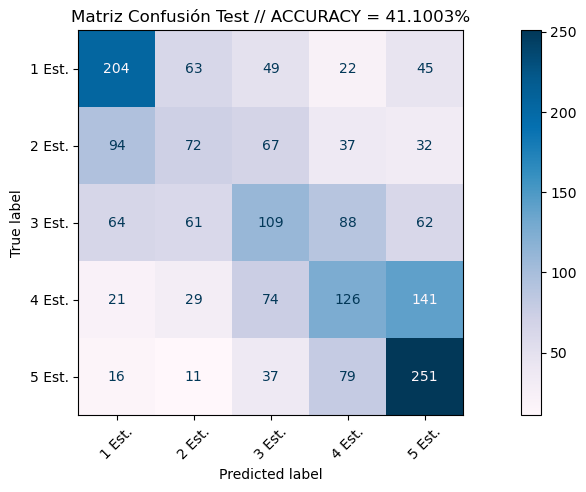

In [80]:
'''
ENSEMBLES - GRADIENTBOOSTING
'''
def tokenizeBPE(text):
    encoding = tokenizer.encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

# Se importa la libreria correspondiente
from sklearn.ensemble import GradientBoostingClassifier

#Creo la pipeline necesaria para automatizar el proceso
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizeBPE,max_df=0.05)),
    ('clasificador', GradientBoostingClassifier(random_state=1))
])

# Genera el diccionario param_grid con los valores indicados
param_grid = {
    'clasificador__learning_rate': [0.05, 0.1, 1],
    'clasificador__n_estimators': [50, 100, 500],
    'clasificador__min_samples_split': [2, 5, 10],
    'clasificador__min_samples_leaf': [1, 2, 5, 10],
    'clasificador__max_features': ['auto', 'sqrt', 'log2', None]
}

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

#Creo el objeto GridSearchCV para crear los mejores parametros
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(X_train_val)
clasificador = crearClasificador(X_train_val,y_train_val,param_grid,sss,scorer,pipeline)
print(clasificador.best_estimator_)

# Mostramos los datos mas interesantes de cada variable predicha
mostrarResultados(clasificador,X,y)

# Obtenemos la matriz de confusión
disp,cm = mostrarMatrizConfusion(clasificador,X_test,y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())
fig, ax = plt.subplots(1, figsize=(15,5))
ax.set_title("Matriz Confusión Test // {} = {}%".format(scorer.upper(),np.round(makeScorer(y_test, clasificador.predict(X_test))*100,4)))
disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)

### Regresion

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.05,
                                 tokenizer=<function tokenizeBPE at 0x7f1ac9801820>)),
                ('clasificador',
                 GradientBoostingRegressor(max_features='auto',
                                           min_samples_leaf=5, n_estimators=500,
                                           random_state=1))])

Results on the test set:
              precision    recall  f1-score   support

           0       0.75      0.11      0.19       383
           1       0.31      0.35      0.33       302
           2       0.26      0.66      0.37       384
           3       0.33      0.35      0.34       391
           4       0.75      0.09      0.16       394

    accuracy                           0.31      1854
   macro avg       0.48      0.31      0.28      1854
weighted avg       0.49      0.31      0.27      1854

37.0941
[3 0 2 ... 2 4 3]
[2.92323993 2.24806108 1.64386184 ... 2.21038566 3.8012

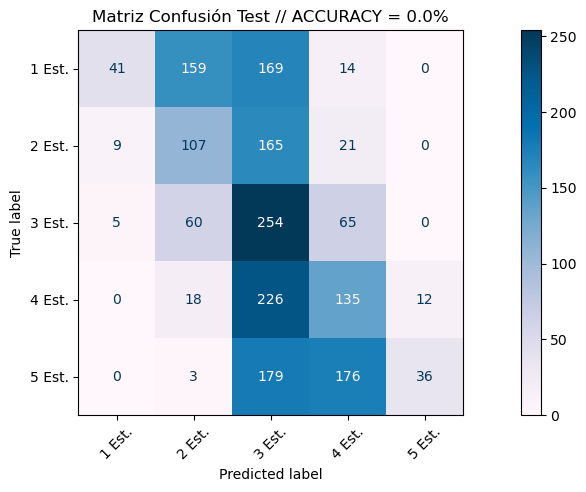

In [53]:
'''
ENSEMBLES - GRADIENTBOOSTING
'''
def tokenizeBPE(text):
    encoding = tokenizer.encode(text)
    return [encoding.tokens[i] for i in range(len(encoding.tokens))]

# Se importa la libreria correspondiente
from sklearn.ensemble import GradientBoostingRegressor

#Creo la pipeline necesaria para automatizar el proceso
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizeBPE,max_df=0.05)),
    ('clasificador', GradientBoostingRegressor(random_state=1))
])

# Genera el diccionario param_grid con los valores indicados
param_grid = {
    'clasificador__learning_rate': [0.05, 0.1, 1],
    'clasificador__n_estimators': [50, 100, 500],
    'clasificador__min_samples_split': [2, 5, 10],
    'clasificador__min_samples_leaf': [1, 2, 5, 10],
    'clasificador__max_features': ['auto', 'sqrt', 'log2', None]
}

# Genera el objeto StratifiedKShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

#Creo el objeto GridSearchCV para crear los mejores parametros
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(X_train_val)
clasificador = crearClasificador(X_train_val,y_train_val_label,param_grid,sss,scorerRegression,pipeline)
print(clasificador.best_estimator_)

# Mostramos los datos mas interesantes de cada variable predicha
y_true, y_pred = y_test_label , clasificador.predict(X_test)
y_pred = np.round(y_pred)
y_pred[y_pred==-1] = 0
y_pred[y_pred==0] = 0
y_pred[y_pred==5] = 4
y_pred = y_pred.astype(int)
print('\nResults on the test set:')
print(classification_report(y_true, y_pred))

# Obtenemos la matriz de confusión
class_names = ['1.0','2.0','3.0','4.0','5.0']
class_namesMatrix = ['1 Est.', '2 Est.', '3 Est.', '4 Est.', '5 Est.']
print(np.round(makeScorerRegression(y_test_label, clasificador.predict(X_test))*100,4))
print(y_test_label)
print(clasificador.predict(X_test))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_namesMatrix)
fig, ax = plt.subplots(1, figsize=(15,5))
ax.set_title("Matriz Confusión Test // {} = {}%".format(scorer.upper(),np.round(makeScorer(y_test, y_pred)*100,4)))
disp.plot(ax=ax,cmap='PuBu',xticks_rotation=45)